# Calculate the output spectrum from LTspice simulation results

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from numba import jit

In [13]:
def output_spectrum(doutfp,fin,Fs,OSR):
    #Calculate the SNR using blackman harris offset=4
    Nfft=len(doutfp)
    Ps=np.abs(np.sum(doutfp[int(Nfft*fin/Fs)-4:int(Nfft*fin/Fs)+4]))
    PN=np.abs(np.sum(doutfp[5:int(Nfft/(2*OSR))]))
    SNDR=10*np.log10(Ps/(PN-Ps))
    #atenuação blackman harris=5.88dB
    text_SNDR=f'SNDR={SNDR:.2f}'+f' dB\n Ps= {10*np.log10(abs(Ps))+5.88:.2f} dB'
    print('Ps=',Ps,'PN=',PN-Ps,text_SNDR)
    freq = np.linspace(0, 1, Nfft)
    plt.semilogx(freq[0:int(Nfft/2)],10*np.log10(abs(doutfp[0:int(Nfft/2)])))
    plt.title(f'Output spectrum SNDR={SNDR:.2f} dB')
    plt.xlabel('Frequency [f/Fs]')
    plt.ylabel('amplitude [dBr]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(1/(2*OSR), color='green') # Bandwidth
    plt.annotate(text_SNDR,
             xy = (fin/Fs, 10*np.log10(abs(doutfp[int(fin*Nfft/Fs)]))),
             xytext = (fin/Fs*10, 10*np.log10(abs(doutfp[int(fin*Nfft/Fs)]))-10),
             arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
             horizontalalignment = 'center')
    #plt.show()

In [14]:
#Ler ficheiro de saída da simulação que deve ter uma duração de Tsim=(40000+Nextra)*Tclk
BW=20e3;    #largura de banda do sinal
Tclk=3.759e-7;  #Periodo de relógio do SDM na simulação electrica
Fs = 1/Tclk; #Frequência de amostragem
Vdd=10;  #valor de Vdd na simulação electrica
OSR=Fs/(2*BW)
Ain=0.5
#namefile='SC_second_order_v1_sem_ruido.txt'
#namefile='SC_second_order_v1_VN_1000uV_Fs_4M.txt'
#namefile='SC_second_order_v1_VN_0_Fs_4M_step_10n.txt'
#namefile='SC_second_order_v1_VN_0_Fs_4M_step_100n.txt'
#namefile='SC_second_order_v1.txt'
#namefile='electrical_model.txt'
namefile='data/electrical_model_v2.txt'
x=np.loadtxt(namefile,skiprows=1)
time=x[:,0]
vdout=x[:,1]

Pontos da sim= 4884734  numero de amostras= 40020


Text(0.5, 1.0, 'Verificar se a saida do modulador é correctamente amostrada no fim')

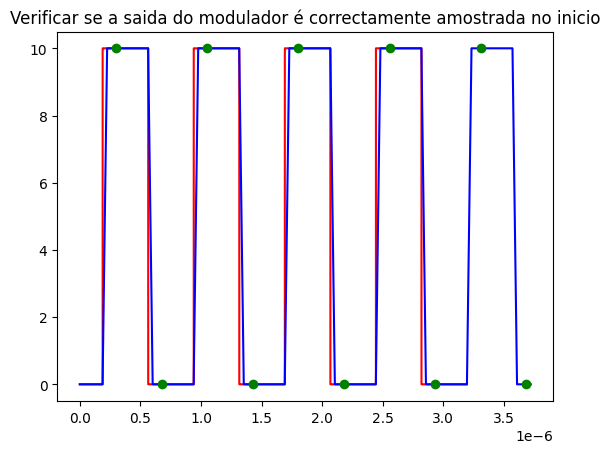

<Figure size 640x480 with 0 Axes>

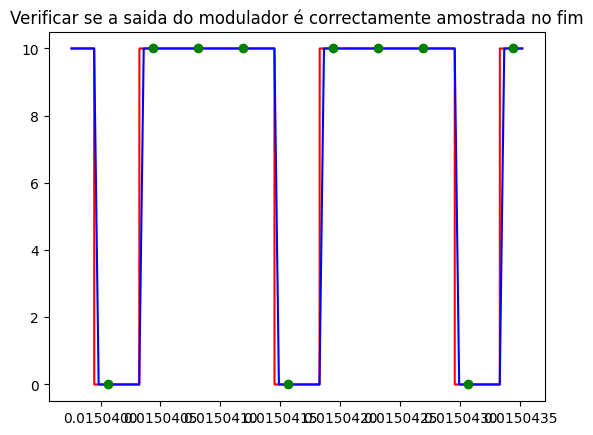

In [15]:
#Criar amostragem uniforme do resultado da simulação e amostrar dout entre +1 e -1
N=len(time)
nclk=int(time[-1]/Tclk); #numero de ciclos de relógio na simulação
np_clk=10; #numero de pontos por ciclo de relógio
dt=Tclk/np_clk; #step time para a interpolação
dts=time[-1]/N #step time médio da simulação electrica
print('Pontos da sim=',N,' numero de amostras=',nclk)

time_inter=np.arange(0,time[-1]+dt/2,dt) 
dout_inter=np.interp(time_inter,time,vdout) #interpolar os valores da simulação para terem amostragem uniforme
sample_ticks=np.arange(int(np_clk*8/10),nclk*np_clk,np_clk) #indices do vector tempo para amostrar dout a meio do relógio
dout_sampled=np.sign(dout_inter[sample_ticks]-0.5)

plot_time=10*Tclk
plt.figure()
plt.plot(time[0:int(plot_time/dts)],vdout[0:int(plot_time/dts)],'r')
plt.plot(time_inter[0:int(plot_time/(dt))],dout_inter[0:int(plot_time/(dt))],'b-')
plt.plot(time_inter[sample_ticks[0:int(plot_time/Tclk)]],(dout_sampled[0:int(plot_time/Tclk)]+1)*Vdd/2,'go')
plt.title('Verificar se a saida do modulador é correctamente amostrada no inicio')
plt.figure()
plot_time=10*Tclk
plt.figure()
plt.plot(time[int((time[-1]-plot_time)/dts):],vdout[int((time[-1]-plot_time)/dts):],'r')
plt.plot(time_inter[int((time[-1]-plot_time)/(dt)):],dout_inter[int((time[-1]-plot_time)/(dt)):],'-b')
plt.plot(time_inter[sample_ticks[int((time[-1]-plot_time)/Tclk):]],(dout_sampled[int((time[-1]-plot_time)/Tclk):]+1)*Vdd/2,'go')
plt.title('Verificar se a saida do modulador é correctamente amostrada no fim')

40000
Ps= 0.03224355784870446 PN= 3.1552933529854776e-09 SNDR=70.09 dB
 Ps= -9.04 dB
OSR= 66.50704974727321 Ps_teo= -9.030899869919436


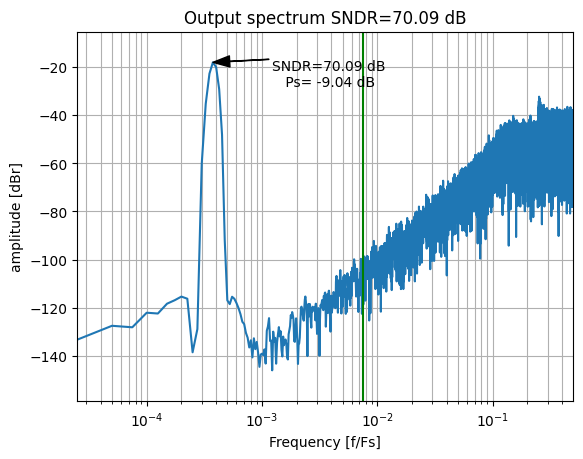

In [16]:
Nextra=20
Nfft=len(dout_sampled[Nextra:]) #Ignorar as primeiras Nextra amostras
print(Nfft)

#Blachman harris window
window = signal.windows.blackmanharris(Nfft)
#rectangular window
#window=np.ones(Nfft)
Fx=1/(Tclk*Nfft)
outf1=np.fft.fft(np.multiply(dout_sampled[Nextra:],window))
outfp1=np.abs(np.multiply(outf1,outf1.conjugate())/((Nfft)**2)*2)

output_spectrum(outfp1,1e3,Fs,OSR)
print('OSR=',OSR,'Ps_teo=',20*np.log10(Ain/np.sqrt(2)))